In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score

# Load transformed dataset
df = pd.read_excel("vroegtijdig-schoolverlaten-woonplaats-dataset-2022-2023.xlsx")

# Expand dataset (assumes original 'vsv_noemer' and 'vsv_teller')
def transform_dataset(bad_df):
    transformed_rows = []
    for _, row in bad_df.iterrows():
        vsv_noemer = row['vsv_noemer']
        vsv_teller = row['vsv_teller']
        for i in range(vsv_noemer):
            new_row = row.copy()
            new_row['vsv_teller'] = 1 if i < vsv_teller else 0
            transformed_rows.append(new_row)
    df = pd.DataFrame(transformed_rows)
    return df.drop(columns=['vsv_noemer'])

df = transform_dataset(df)
df = df.drop(columns=['schooljaar'])  # Drop non-informative
X = df.drop(columns=['vsv_teller'])
y = df['vsv_teller']

In [2]:
# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
# Define preprocessing
categorical_cols = X.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='passthrough'
)

# Define model configs
models = {
    "Logistic Regression": Pipeline([
        ("pre", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, class_weight=None))
    ]),
    "Random Forest": Pipeline([
        ("pre", preprocessor),
        ("clf", RandomForestClassifier(class_weight=None, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("pre", preprocessor),
        ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
    ]),
    "Random Forest + SMOTE": ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "XGBoost + Cost-sensitive": Pipeline([
        ("pre", preprocessor),
        ("clf", XGBClassifier(scale_pos_weight=5, use_label_encoder=False, eval_metric="logloss"))
    ])
}

In [4]:
# Evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    return {
        "Model": name,
        "Recall (class 1)": round(recall, 2),
        "F1 (class 1)": round(f1, 2),
        "FPR": round(fpr, 3),
        "FNR": round(fnr, 3),
        "ROC-AUC": round(auc, 3)
    }

In [5]:
# Train and evaluate all models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    results.append(evaluate_model(name, model, X_test, y_test))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

C:\Users\mouni\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\mouni\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                      Model  Recall (class 1)  F1 (class 1)    FPR    FNR  \
0       Logistic Regression              0.70          0.79  0.010  0.303   
1             Random Forest              0.70          0.79  0.012  0.299   
2                   XGBoost              0.70          0.80  0.008  0.298   
3     Random Forest + SMOTE              0.73          0.79  0.018  0.271   
4  XGBoost + Cost-sensitive              0.80          0.75  0.052  0.195   

   ROC-AUC  
0    0.943  
1    0.934  
2    0.944  
3    0.934  
4    0.944  


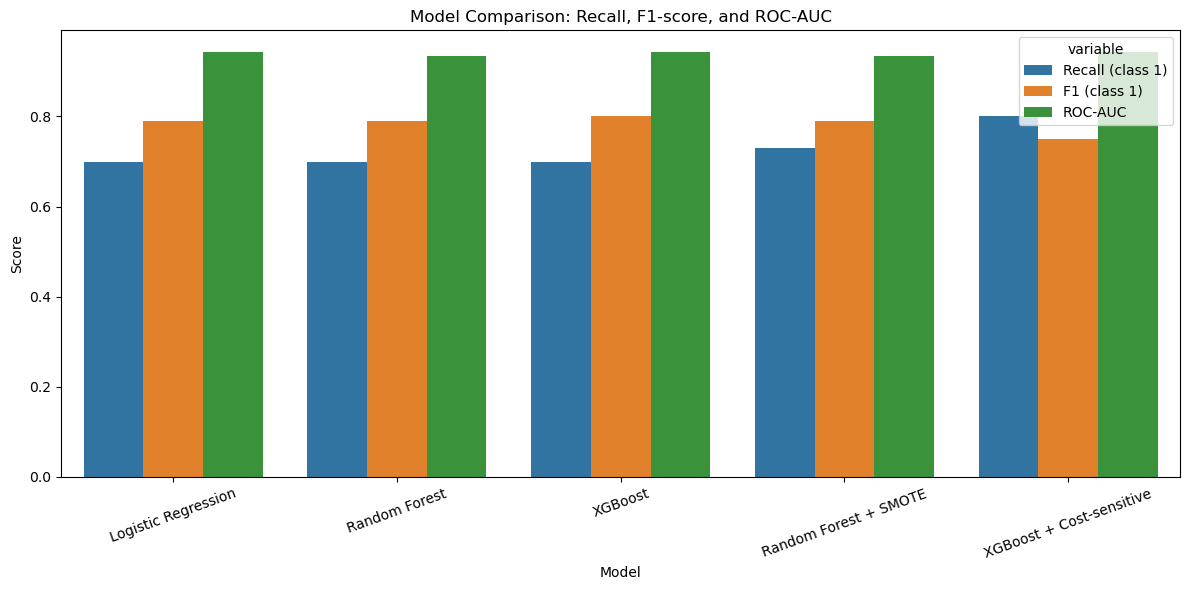

In [6]:
# Plot Figure 10
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars='Model', value_vars=['Recall (class 1)', 'F1 (class 1)', 'ROC-AUC']),
            x='Model', y='value', hue='variable')
plt.xticks(rotation=20)
plt.ylabel("Score")
plt.title("Model Comparison: Recall, F1-score, and ROC-AUC")
plt.tight_layout()
plt.savefig("model_comparison_chart.png")
plt.show()